In [ ]:
# Предварительно импортируем необходимые библиотеки
import pandas as pd
import datetime
import requests

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import pickle

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


import numpy as np
import os

np.random.seed(42)

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt


In [16]:
import requests#Чтение данных
#file_n = ('https://github.com/HMelhoff/ML/blob/bf79122a53ab71f221f448d599ca596a1a864246/dataset/MLTempDataset1.csv')
#txt = file_n.content
temp_data = pd.read_csv("/dataset/MLTempDataset1.csv")

In [17]:
temp_data

,Unnamed: 0,Datetime,Hourly_Temp
0,0,2022-01-04 00:00:00,20.867
1,1,2022-01-04 01:00:00,21.000
2,2,2022-01-04 02:00:00,20.867
3,3,2022-01-04 03:00:00,20.650
4,4,2022-01-04 04:00:00,20.400
...,...,...,...
7051,7051,2022-10-24 19:00:00,25.567
7052,7052,2022-10-24 20:00:00,25.183
7053,7053,2022-10-24 21:00:00,24.600
7054,7054,2022-10-24 22:00:00,23.986


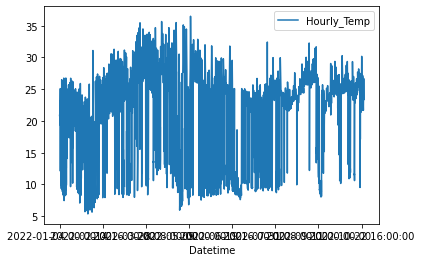

In [18]:
temp_data.plot("Datetime", "Hourly_Temp")

In [41]:
X_df = pd.DataFrame(list(map(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'), temp_data["Datetime"])))
#list(map(lambda x: x.split(" "), temp_data["Datetime"]))
Y_df = temp_data["Hourly_Temp"]

In [40]:
X_df_F = list(map(lambda x: (x - X_df[0]), X_df))
X_df_S = list(map(lambda x: (x - X_df[0]).seconds, X_df))
#X_df_F[:50]

In [22]:
print(type(X_df[0]))
print(X_df[0])

<class 'datetime.datetime'>
2022-01-04 00:00:00


In [23]:
len(X_df)

7056

In [51]:
chunk_size_D = 24
chunk_size_W = 24*7

Y_df_D = [Y_df[x:x+chunk_size_D] for x in range(0, len(Y_df), chunk_size_D)]
Y_df_W = [Y_df[x:x+chunk_size_W] for x in range(0, len(Y_df), chunk_size_W)]

X_df_D = pd.DataFrame([list(range(24))]*int(len(X_df)/24))
X_df_W = [list(range(24*7))]*int(len(X_df)/(24*7))
X_df_A = pd.DataFrame(list(range(len(X_df))))


In [55]:
Bd = pd.DataFrame()
Bd.insert(0, "time", X_df_A)

In [57]:
Bd.insert(1, "temp", Y_df)

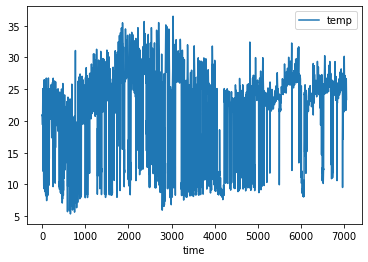

In [65]:
Bd.plot("time", "temp")

In [61]:
split = 0.8
i_split = int(len(X_df)*split)
cols = ["time", "temp"]
data_train = Bd.get(cols).values[:i_split]
data_test = Bd.get(cols).values[i_split:]
len_train = len(data_train)
len_test = len(data_test)
print(len(Bd), len_train, len_test)

7056 5644 1412


In [64]:
sequence_length = 50
input_dim = 2
batch_size = 32
epochs = 2

In [68]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(100, input_shape=(sequence_length-1, input_dim), return_sequences=True),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.LSTM(100, return_sequences=True),
    tf.keras.layers.LSTM(100, return_sequences=False),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(1, activation = "linear")
])

In [70]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 49, 100)           41200     
                                                                 
 dropout_2 (Dropout)         (None, 49, 100)           0         
                                                                 
 lstm_8 (LSTM)               (None, 49, 100)           80400     
                                                                 
 lstm_9 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 202,101
Trainable params: 202,101
Non-tr

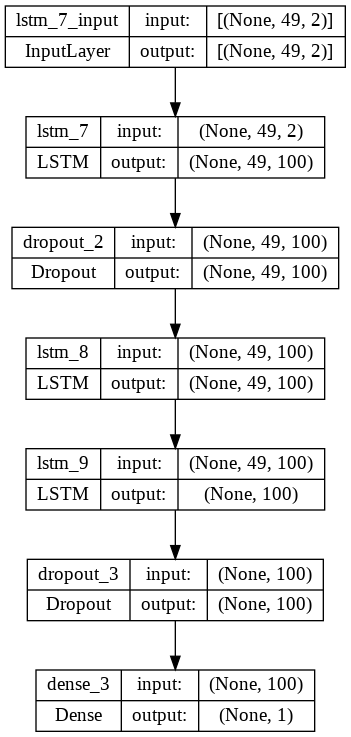

In [71]:
tf.keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

In [73]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy'])

In [157]:
def normalise_windows(window_data, single_window=False):
  normalised_data = []
  window_data = [window_data] if single_window else window_data
  for window in window_data:
    normalised_window = []
    for col_i in range(window.shape[1]):
      if col_i == 1:
        normalised_col = [((float(p)/float(window[0, col_i])) - 1) for p in window[:, col_i]]
      elif col_i == 0:
        normalised_col = [float(p-window[0,0]) for p in window[:, col_i]]
      normalised_window.append(normalised_col)
    normalised_window = np.array(normalised_window).T
    normalised_data.append(normalised_window)
  return np.array(normalised_data)

In [158]:
def _next_window(i, seq_len, normalise):
  window = data_train[i:i+seq_len]
  window = normalise_windows(window, single_window=True)[0] if normalise else window
  x = window[:-1]
  y = window[-1, [0]]
  return x, y

In [159]:
def get_train_data(seq_len, normalise):
  data_x = []
  data_y = []
  for i in range(len_train - seq_len + 1):
    x, y = _next_window(i, seq_len, normalise)
    data_x.append(x)
    data_y.append(y)
  return np.array(data_x), np.array(data_y)

In [160]:
x, y = get_train_data(
    seq_len = sequence_length,
    normalise = True
)

In [161]:
import math

steps_per_epoch = math.ceil((len_train - sequence_length)/batch_size)
print(steps_per_epoch)

175


In [162]:
batch_size = 32

In [163]:
from keras.callbacks import EarlyStopping
callbacks = [EarlyStopping(monitor="val_loss", patience=2)]

In [164]:
callbacks = [EarlyStopping(monitor="accuracy", patience=2)]

In [165]:
model.fit(x, y, epochs=epochs, batch_size = batch_size, callbacks =  callbacks)

Epoch 1/2
175/175 [==============================] - 14s 78ms/step - loss: 7.0234 - accuracy: 0.0000e+00
Epoch 2/2
175/175 [==============================] - 13s 76ms/step - loss: 6.8691 - accuracy: 0.0000e+00


In [166]:
def get_test_data(seq_len, normalise):
  data_windows = []
  for i in range(len_test - seq_len):
    data_windows.append(data_test[i:i+seq_len])

  data_windows = np.array(data_windows).astype(float)
  data_windows = normalise_windows(data_windows, single_window = False) if normalise else data_windows

  x = data_windows[:,:-1]
  y = data_windows[:, -1, [0]]
  return x, y

In [169]:
x_test, y_test = get_test_data(
    seq_len = sequence_length,
    normalise = True
)
x_test[:, 1, 0]

array([1., 1., 1., ..., 1., 1., 1.])

In [168]:
model.evaluate(x_test, y_test, verbose = 2)

43/43 - 1s - loss: 0.9432 - accuracy: 0.0000e+00 - 928ms/epoch - 22ms/step


[0.9431835412979126, 0.0]

In [176]:
def get_last_data(seq_len, normalise):
  last_data = data_test[seq_len:]
  data_windows = np.array(last_data).astype(float)
  data_windows = normalise_windows(data_windows, single_window=True) if normalise else data_windows
  return data_windows

In [184]:
last_data = get_last_data(-(sequence_length-1), False)
pre_first = last_data[0][0]
last_data = get_last_data(-(sequence_length-1), True)


In [192]:
last_data

array([[[ 0.00000000e+00,  0.00000000e+00],
        [ 1.00000000e+00, -2.82107532e-02],
        [ 2.00000000e+00, -5.13027749e-02],
        [ 3.00000000e+00, -7.43947966e-02],
        [ 4.00000000e+00, -9.42924220e-02],
        [ 5.00000000e+00, -1.13150906e-01],
        [ 6.00000000e+00, -1.28661048e-01],
        [ 7.00000000e+00, -1.44325136e-01],
        [ 8.00000000e+00, -1.57141208e-01],
        [ 9.00000000e+00, -1.64184274e-01],
        [ 1.00000000e+01, -1.53946811e-01],
        [ 1.10000000e+01, -1.28930455e-01],
        [ 1.20000000e+01, -9.04437517e-02],
        [ 1.30000000e+01, -5.39968441e-02],
        [ 1.40000000e+01, -2.94808144e-02],
        [ 1.50000000e+01,  1.15460109e-04],
        [ 1.60000000e+01,  2.63249047e-02],
        [ 1.70000000e+01,  4.49139822e-02],
        [ 1.80000000e+01,  4.14501790e-02],
        [ 1.90000000e+01,  2.44005696e-02],
        [ 2.00000000e+01, -4.46445753e-03],
        [ 2.10000000e+01, -2.47469499e-02],
        [ 2.20000000e+01, -3.848

In [193]:
predict = model.predict(last_data)
print(predict, predict[0][0])

1/1 [==============================] - 0s 34ms/step
[[48.028824]] 48.028824


In [194]:
def de_norm(pre, _data):
  return (_data -1)*pre

In [195]:
pred_pre = de_norm(pre_first, predict[0][0])
pred_pre

329530.9687347412